In [1]:
print('What\'s up?')

What's up?


## Notebook Imports

In [2]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## Constants

In [4]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email_text_data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
CUSTEM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(type(email_body))

<class 'str'>


In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

## Generator Function

In [7]:
def generate_squares(n):
    for i in range(n):
        yield i**2

In [8]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

## Email Body Extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        #print(root)
        for file_name in filenames:
            
            file_path = join(root, file_name)
                        
            stream = open(file_path, encoding='latin-1')
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE' : email_body, 'CATEGORY' : classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of data: ', data.shape)
data.head()

Shape of data:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [15]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


## Data Cleaning : Checking for Missing Values

In [16]:
# check if any message bodu are null
data['MESSAGE'].isnull().values.any()

False

In [17]:
type('')

str

In [18]:
len('')

0

In [19]:
my_var = None
type(my_var)

NoneType

In [20]:
# check if there are empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).sum()

3

### Locate empty emails

In [22]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [23]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

### Remove System File Entries from Dataframe

In [24]:
data.drop(['cmds'], inplace=True)
data.shape

(5796, 2)

### Add Document IDs to Track Emails in Datasets

In [25]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [26]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


## Save to File using pandas

In [27]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised(Pie Charts)

In [28]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [29]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

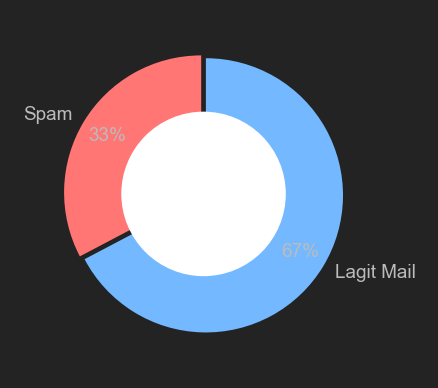

In [30]:
category_names = ['Spam', 'Lagit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize' : 6}, startangle=90, 
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.80, explode=(0.02, 0.02))

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

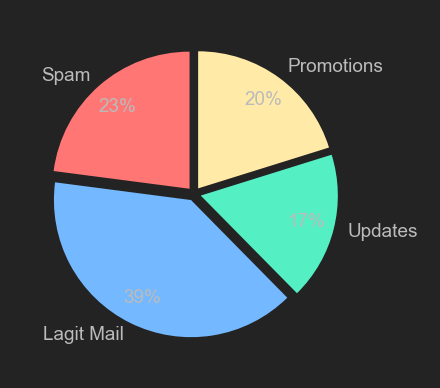

In [31]:
# fake charts(for practice)
category_names = ['Spam', 'Lagit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize' : 6}, startangle=90, 
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.80, explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')

plt.show()

## Natrual Language Processing

### Text Pre-Processing

In [32]:
# convert to lower case
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### Download the NLTK Resources(Tokenizer & Stopwords)

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\India\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\India\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\India\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\India\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenising

In [36]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### Removing Stop Words

In [37]:
stop_words = set(stopwords.words('english'))

In [38]:
type(stop_words)

set

In [39]:
if 'this' in stop_words : print('Found it!')

Found it!


In [40]:
if 'hello'not in stop_words : print('Nope. Not in here')

Nope. Not in here


In [41]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']


### Word Stems and Stemming

In [42]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be \
        Nobody expects the Spanish Inuisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', 'nobodi', 'expect', 'spanish', 'inuisit', '!']


### Removing Punctuation

In [43]:
'p'.isalpha()

True

In [44]:
'?'.isalpha()

False

In [45]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. ?? \
        Nobody expects the Spanish Inuisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inuisit']


### Removing HTML Tags From Emails

In [46]:
soup = BeautifulSoup(data.at[213,'MESSAGE'])
print(soup.prettify)

<bound method Tag.prettify of <html><body><p>This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.co

In [47]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

## Function for Email Processing

In [48]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # Convert to Lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
        
    return filtered_words

In [49]:
print(clean_message(email_body))

['dear', 'mr', 'still', 'good', 'tide', 'staff', 'festiv', 'season', 'ahead', 'christma', 'crux', 'fulli', 'qualifi', 'santa', 'clau', 'wonder', 'whether', 'might', 'consid', 'run', 'santa', 'grotto', 'store', 'wait', 'probabl', 'think', 'make', 'special', 'well', 'first', 'made', 'sever', 'chang', 'characteris', 'father', 'christma', 'rather', 'greet', 'children', 'shout', 'ho', 'ho', 'ho', 'prefer', 'whisper', 'phrase', 'depend', 'unfathom', 'cruel', 'world', 'live', 'addit', 'gift', 'rang', 'felt', 'hoop', 'holder', 'note', 'also', 'enclos', 'sketch', 'radic', 'redesign', 'santa', 'outfit', 'renam', 'charact', 'lord', 'buckl', 'would', 'interest', 'employ', 'promis', 'never', 'let', 'look', 'forward', 'hear', 'best', 'wish', 'robin', 'cooper', 'excerpt', 'book', 'timewast', 'letter', 'robin', 'cooper']


In [50]:
def clean_message_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # Removing HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Convert to Lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
        
    return filtered_words

In [51]:
print(clean_message_no_html(data.at[213, 'MESSAGE']))

['messag', 'mime', 'format', 'dare', 'tri', 'find', 'better', 'annuiti', 'guarante', 'year', 'surrend', 'agent', 'commiss', 'age', 'call', 'today', 'inform', 'ext', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'pmg', 'financi', 'servic', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'commun', 'sent', 'insur', 'profession', 'remov', 'mail', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic', 'dare', 'find', 'better', 'annuiti', 'call', 'today', 'inform', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'sent', 'insur', 'profession', 'remov', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic']


## Apply Cleaning and Tokenisation to all Messages

### Slicing DataFrames and Series & Creating Subsets

In [52]:
data.iat[2, 0]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [53]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [54]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [55]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

321

In [56]:
%%time

# use apply()  on all message in the DataFrame
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\India\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 48.5 s


In [57]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframe

In [58]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [59]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
1894,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
1895,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [60]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [61]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [62]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [63]:
type(nested_list)

pandas.core.series.Series

In [64]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [65]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [66]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [67]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape

(20755,)

In [68]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [69]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape

(13284,)

In [70]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Creating Wordcloud

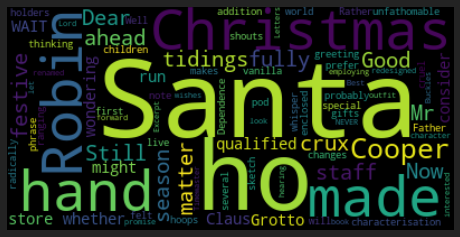

In [71]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [72]:
example_corpus = nltk.corpus.gutenberg.words(
    'melville-moby_dick.txt')
len(example_corpus)

260819

In [73]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [74]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [75]:
word_list = [''.join(word) for word in example_corpus ]
novel_as_string = ' '.join(word_list)

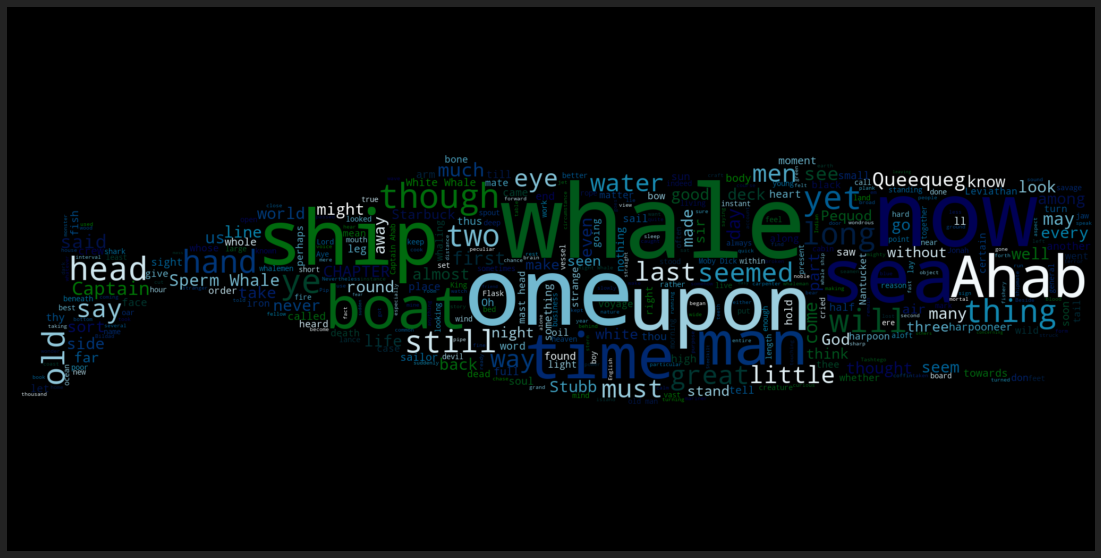

In [76]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[20, 10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

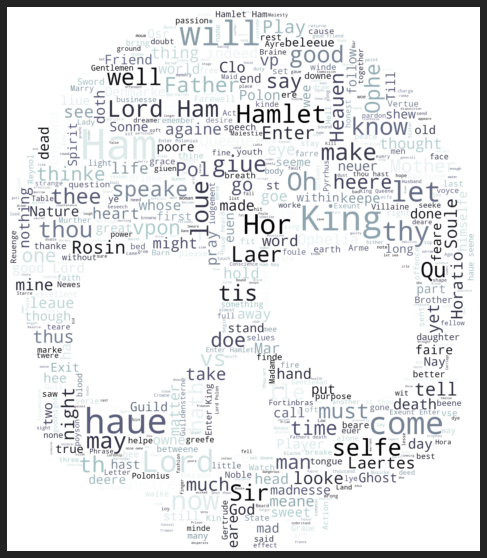

In [77]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list_hamlet = [''.join(word) for word in hamlet_corpus ]
novel_hamlet = ' '.join(word_list_hamlet)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',max_words=600, colormap='bone')
word_cloud.generate(novel_hamlet)

plt.figure(figsize=[20, 10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word cloud fo Ham and Spam Message

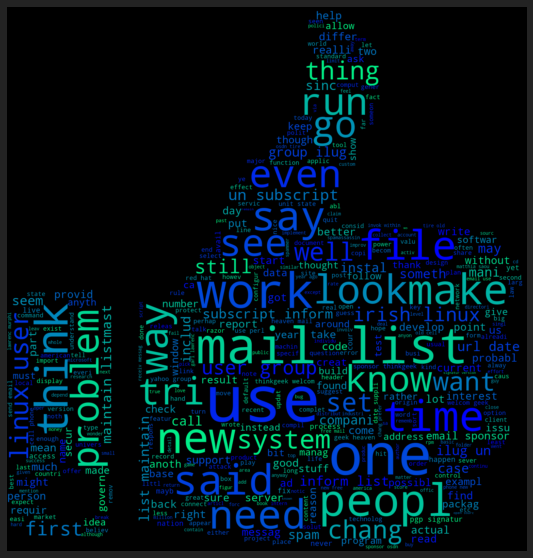

In [78]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, max_words=400, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[20, 10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

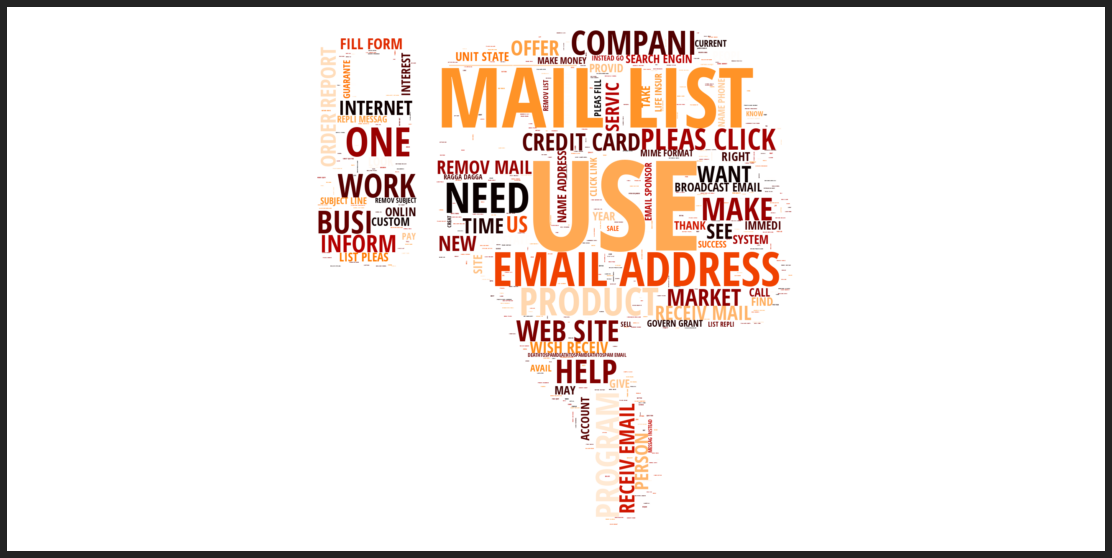

In [79]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, max_words=500, colormap='gist_heat', background_color='white', 
                      max_font_size=300, font_path=CUSTEM_FONT_FILE)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[20, 10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [80]:
flat_stemmed_list = [item for sublist in nested_list for item in sublist]

In [81]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('No. of unique words: ',unique_words.shape)
unique_words.head()

No. of unique words:  (27305,)


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [82]:
frequent_words = unique_words[:VOCAB_SIZE]
print('Most commwords: \n', frequent_words[:10])

Most commwords: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create Vocabulary Dataframe with a WORD_ID

In [83]:
word_id = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD' : frequent_words.index.values}, index=word_id)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [84]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [85]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [86]:
'science' in set(vocab.VOCAB_WORD) # better way

False

## Exercise: Find the Email with the Most Number of words

In [87]:
clean_email_lengths = [len(email) for email in nested_list]
print('nr of word in longest email:', max(clean_email_lengths))

nr of word in longest email: 7671


In [88]:
print('Email position in the list(and the data dataframe): ', np.argmax(clean_email_lengths))

Email position in the list(and the data dataframe):  5775


In [89]:
nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [90]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generate Features and a Sparse Matrix
### Creating a DataFrame with One Word per Column

In [91]:
type(nested_list)

pandas.core.series.Series

In [92]:
type(nested_list.to_list())

list

In [93]:
word_column_df = pd.DataFrame.from_records(nested_list.to_list())
word_column_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [94]:
word_column_df.shape

(5796, 7671)

## Splitting the Data into Training and Testing Dataset

In [95]:
x_train, x_test, y_train, y_test = train_test_split(word_column_df, data.CATEGORY, test_size=0.3, random_state=42)

In [96]:
print('no of training sample',x_train.shape[0])
print('Fractoin of training set', x_train.shape[0] / word_column_df.shape[0])

no of training sample 4057
Fractoin of training set 0.6999654934437544


In [97]:
x_train.index.name = x_test.index.name = 'DOC_ID'
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [98]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

##  Create a Sparse Matrix for the Training Data

In [99]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [100]:
word_index.get_loc('thu')

395

In [101]:
def make_sparse_matrix(df, indexed_word, labels):
    """
    Returns the sparse matrix  as a Dataframe
    
    df: A Dataframe with the words in the column with a document id as an index (x_train or x_test)
    indexed_word: undex of the word ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_word)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_word.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL' : category, 'DOC_ID' : doc_id, 'OCCURRENCE' : 1, 'WORD_ID' : word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
    

In [102]:
%%time

sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)

Wall time: 4min 5s


In [103]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURRENCE,WORD_ID
0,0,4844,1,266
1,0,4844,1,1262
2,0,4844,1,507
3,0,4844,1,310
4,0,4844,1,255


In [104]:
sparse_train_df.shape

(431024, 4)

In [105]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURRENCE,WORD_ID
431019,1,860,1,47
431020,1,860,1,1437
431021,1,860,1,26
431022,1,860,1,19
431023,1,860,1,126


## Combine Occurrences with the pandas groupby() method

In [106]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped[:5]

OCCURRENCE
DOC_ID WORD_ID LABEL            
0      2       1               1
       3       1               2
       4       1               1
       7       1               3
       11      1               1

In [107]:
vocab.at[3, 'VOCAB_WORD']

'email'

In [108]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [109]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [110]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
258315,5795,2058,0,1
258316,5795,2060,0,2
258317,5795,2283,0,1
258318,5795,2364,0,1
258319,5795,2433,0,1


In [111]:
train_grouped.shape

(258320, 4)

## Save Training Data as .txt File

In [112]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

## Challenge

In [113]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [114]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [115]:
x_test.shape

(1739, 7671)

In [116]:
%%time
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)

Wall time: 1min 22s


In [117]:
sparse_test_df.shape

(203109, 4)

In [119]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [120]:
test_grouped.shape

(117613, 4)

In [121]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## Pre-Processing Subtleties and Checking your Undersatnding

In [122]:
train_doc_id = set(train_grouped.DOC_ID)
test_doc_id = set(test_grouped.DOC_ID)

In [125]:
len(test_doc_id)

1724

In [126]:
len(x_test)

1739

In [147]:
set(x_test.index.values) - test_doc_id

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [152]:
data.MESSAGE[439]

'------=_NextPart_000_00A6_30E15B3E.B5031C68\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPCFET0NUWVBFIEhUTUwgUFVCTElDICItLy9XM0MvL0RURCBIVE1MIDMuMi8v\n\nRU4iPg0KPEhUTUw+DQoNCjxIRUFEPg0KCTxNRVRBIE5BTUU9IkdFTkVSQVRP\n\nUiIgQ29udGVudD0iVmlzdWFsIFBhZ2UgMS4wIGZvciBXaW5kb3dzIj4NCgk8\n\nTUVUQSBIVFRQLUVRVUlWPSJDb250ZW50LVR5cGUiIENPTlRFTlQ9InRleHQv\n\naHRtbDtDSEFSU0VUPWlzby04ODU5LTEiPg0KCTxUSVRMRT51bnRpdGxlZDwv\n\nVElUTEU+DQo8L0hFQUQ+DQoNCjxCT0RZIG9uTG9hZD0iKHdpbmRvdy5vcGVu\n\nKCdodHRwOi8vZXVyby5zcGVjaWFsZGlzY291bnRzNHUuY29tLycpKSI+DQoN\n\nCjxQIEFMSUdOPSJDRU5URVIiPjxGT05UIENPTE9SPSIjMDAwMEZGIiBmYWNl\n\nPSJBcmlhbCI+PEI+QVRURU5USU9OOiBUaGlzIGlzIGEgTVVTVCBmb3IgQUxM\n\nIENvbXB1dGVyIFVzZXJzISEhPEJSPg0KPC9CPjwvRk9OVD48Rk9OVCBDT0xP\n\nUj0iIzAwMDAwMCIgZmFjZT0iQXJpYWwiPjxCUj4NCjwvRk9OVD48Rk9OVCBm\n\nYWNlPSJBcmlhbCI+PEI+Kk5FVy1TcGVjaWFsIFBhY2thZ2UgRGVhbCEqPEJS\n\nPg0KPC9CPjwvRk9OVD48Rk9OVCBDT0xPUj0iIzAwMDAwMCIgZmFjZT0iQXJp\n\nYWwiPjxCUj4NCjwvRk9OVD48Rk

In [153]:
clean_message_no_html(data.at[439, 'MESSAGE'])

[]

In [155]:
data.MESSAGE[734]

'<html>\n\n<body bgcolor="#7CB5F0">\n\n<a href="http://teens.xxxfreehosting.com/hotteens/index.html"><img border="0" src="http://members.aol.com/tjoyce/mail_01.gif" width="500" height="558" border=0></a><br>\n\n<a href="mailto:flojo@btamail.net.cn"><img border="0" src="http://members.aol.com/tjoyce/mail_02.gif" width="500" height="42" border=0>\n\n</a>\n\n</body>\n\n</html>\n\n4623\n\n\n\n\n'

In [156]:
clean_message(data.at[734, 'MESSAGE'])

['html', 'bodi', 'http', 'img', 'http', 'br', 'mailto', 'flojo', 'img', 'http']

In [157]:
clean_message_no_html(data.at[734, 'MESSAGE'])

[]